## 7. Queuing Model (90 pts)

In [1]:
%load_ext autoreload
%autoreload 2

from queries import query_mw as q_mw
from queries import query_client as q_client
from queries import exp_filter

from plots.ctrl import generate, dashboard_nc, dashboard_time, export
from plots import tp, rt, queue, qwt, utilization

import matplotlib.pyplot as plt
import math
import pandas as pd
import oct2py
import pprint

oc = oct2py.Oct2Py()

oc.eval("pkg load queueing")

suite={
    "exp41":"simulation_p2",
    "exp31":"simulation_p2",
    "exp32":"simulation_p2"
}

%matplotlib inline
output_folder = "result"

In [2]:
exp_name="exp41"
df_exp41_mw = q_mw.load_df(suite=suite[exp_name], exp=exp_name)
df_exp41_client = q_client.load_df(suite=suite[exp_name], exp=exp_name)

### 7.1 M/M/1 and 7.2 M/M/m

In [3]:
max_tp_w8 = math.ceil(df_exp41_mw[df_exp41_mw['n_worker_per_mw']==8]['throughput_rep_mean'].max())
max_tp_w16 = math.ceil(df_exp41_mw[df_exp41_mw['n_worker_per_mw']==16]['throughput_rep_mean'].max())
max_tp_w32 = math.ceil(df_exp41_mw[df_exp41_mw['n_worker_per_mw']==32]['throughput_rep_mean'].max())
max_tp_w64 = math.ceil(df_exp41_mw[df_exp41_mw['n_worker_per_mw']==64]['throughput_rep_mean'].max())
print(f" 8 worker: max tp= {max_tp_w8}")
print(f"16 worker: max tp= {max_tp_w16}")
print(f"32 worker: max tp= {max_tp_w32}")
print(f"64 worker: max tp= {max_tp_w64}")

      
mm1_service_rate = {
    8 : max_tp_w8,
    16: max_tp_w16,
    32: max_tp_w32,
    64: max_tp_w64
}

mmm_service_rate = {
    8 : max_tp_w8/(8*2),
    16: max_tp_w16/(16*2),
    32: max_tp_w32/(32*2),
    64: max_tp_w64/(64*2)
}

print("\nM/M/1 Service Rate: ")
print(mm1_service_rate)

print("\nM/M/m Servie Rate: ")
print(mmm_service_rate)



 8 worker: max tp= 6385
16 worker: max tp= 8313
32 worker: max tp= 10504
64 worker: max tp= 11848

M/M/1 Service Rate: 
{8: 6385, 16: 8313, 32: 10504, 64: 11848}

M/M/m Servie Rate: 
{8: 399.0625, 16: 259.78125, 32: 164.125, 64: 92.5625}


In [4]:
def _mm1(arrival_rate, service_rate):
    utilization, rt, n_jobs_system, tp, p0 = oc.eval(f"qsmm1({arrival_rate}, {service_rate})",nout=5)
    
    traffic_intensity = utilization
    n_jobs_queue = traffic_intensity**2 / (1-traffic_intensity)
    busy_period = 1 / (service_rate*(1-traffic_intensity))
    
    qwt = traffic_intensity * (1/service_rate)/(1-traffic_intensity)
    
    d = {
        "mm1_traffic_intensity": traffic_intensity,
        "mm1_rt": rt*1000,
        "mm1_n_jobs_system": n_jobs_system,
        "mm1_n_jobs_queue": n_jobs_queue,
        "mm1_qwt":qwt*1000,
        "mm1_tp":tp,
        "mm1_p0":p0,
        "mm1_busy_period":busy_period*1000
    }
    
    return d



def _mmm(arrival_rate, service_rate, m):
    utilization_per_server, rt, n_jobs_system, tp, p0, p_queueing = oc.eval(f"qsmmm({arrival_rate}, {service_rate}, {m})",nout=6)
        
    traffic_intensity = utilization_per_server
    n_jobs_queue = traffic_intensity * p_queueing / (1-traffic_intensity)
    n_jobs_service = m * traffic_intensity
    
    qwt = p_queueing / (m*service_rate*(1-traffic_intensity))
    
    
    d = {
        "mmm_traffic_intensity": traffic_intensity,
        "mmm_rt": rt*1000,
        "mmm_n_jobs_system": n_jobs_system,
        "mmm_n_jobs_service": n_jobs_service,
        "mmm_n_jobs_queue": n_jobs_queue,
        "mmm_qwt":qwt*1000,
        "mmm_tp":tp,
        "mmm_p0":p0,
        "mmm_p_queueing":p_queueing,
    }
    return d

def print_latex_table_queue_param(df):

    df = df[['n_worker_per_mw', 'num_clients', 'arrival_rate', 'mm1_traffic_intensity', 'mmm_traffic_intensity']].round({'arrival_rate': 0, 'mm1_traffic_intensity': 2, 'mmm_traffic_intensity': 2})

    df = df.sort_values(['n_worker_per_mw', 'num_clients'])

    header = """\\begin{center}
    \\begin{tabular}{r|lcccccccc|}
    \\multicolumn{3}{c}{}  & \\multicolumn{7}{c}{Number of Clients}\Tstrut \\\\ 
    \\multicolumn{3}{c}{}   & 6 & 12 & 24 & 48 & 72 & 96 & \\multicolumn{1}{c}{144} \\\\ 
    \\cline{2-10}"""

    print(header)
    for n_worker in df['n_worker_per_mw'].unique():
        dfw  = df[df['n_worker_per_mw']==n_worker]
        x = " & ".join(map(str, dfw['arrival_rate'].values.astype(int)))
        print(f"\\multirow{{2}}{{*}}{{{n_worker} WT }} & $\\mu_{{M/M/1}} = {round(mm1_service_rate[n_worker])}$ & $\\lambda = $ & {x}\Tstrut \\\\")
        x = " & ".join(map(str, dfw['mm1_traffic_intensity'].values))
        print(f"& $\\mu_{{M/M/{2*n_worker}}} = {round(mmm_service_rate[n_worker])}$ & $\\rho =$ & {x} \\\\")
        print("\\cline{2-10}")
    print("\\end{tabular}\n\\end{center}")

Worker: 8


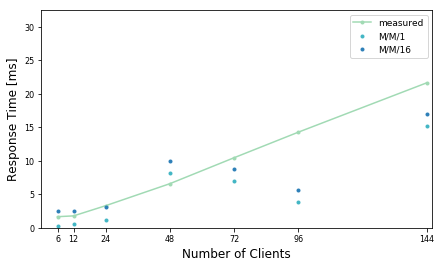

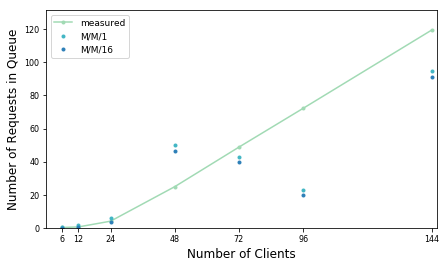

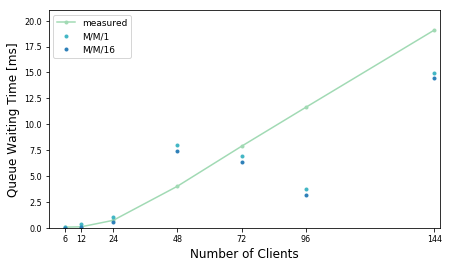

Worker: 16


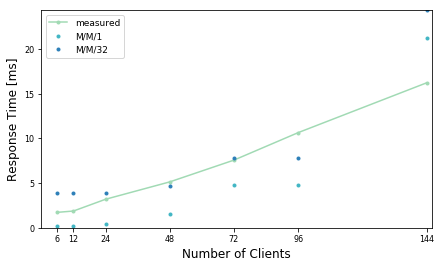

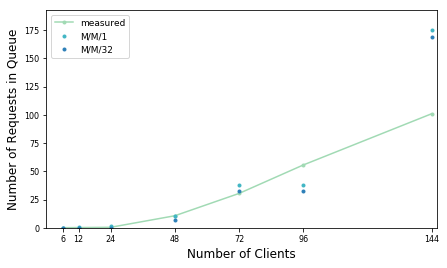

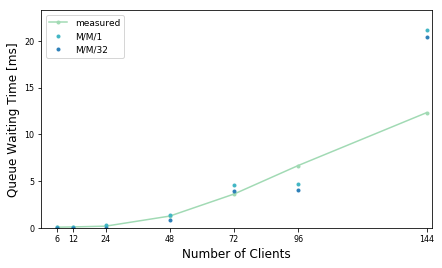

Worker: 32


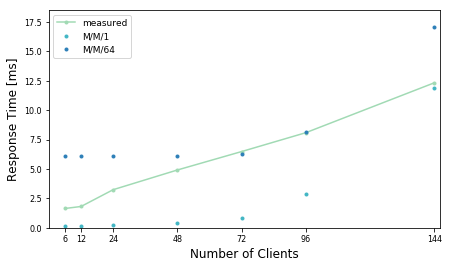

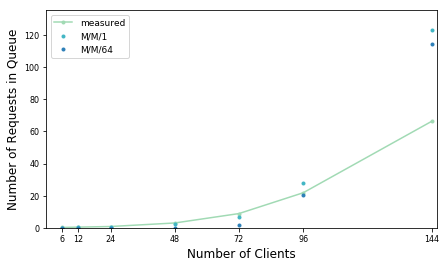

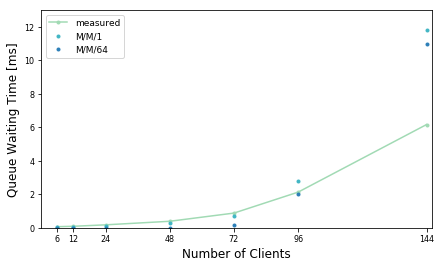

Worker: 64


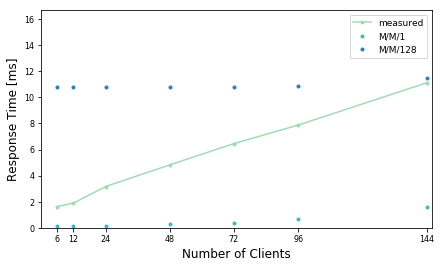

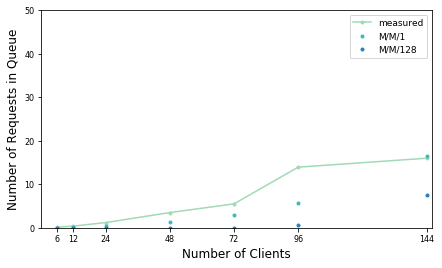

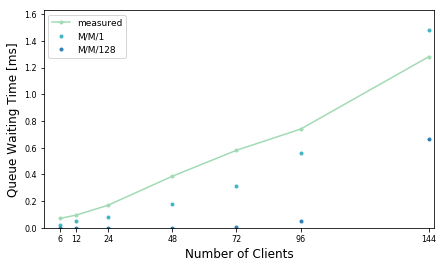

\begin{center}
    \begin{tabular}{r|lcccccccc|}
    \multicolumn{3}{c}{}  & \multicolumn{7}{c}{Number of Clients}\Tstrut \\ 
    \multicolumn{3}{c}{}   & 6 & 12 & 24 & 48 & 72 & 96 & \multicolumn{1}{c}{144} \\ 
    \cline{2-10}
\multirow{2}{*}{8 WT } & $\mu_{M/M/1} = 6385$ & $\lambda = $ & 2357 & 4520 & 5562 & 6262 & 6244 & 6129 & 6320\Tstrut \\
& $\mu_{M/M/16} = 399$ & $\rho =$ & 0.37 & 0.71 & 0.87 & 0.98 & 0.98 & 0.96 & 0.99 \\
\cline{2-10}
\multirow{2}{*}{16 WT } & $\mu_{M/M/1} = 8313$ & $\lambda = $ & 2312 & 4335 & 5699 & 7664 & 8103 & 8105 & 8266\Tstrut \\
& $\mu_{M/M/32} = 260$ & $\rho =$ & 0.28 & 0.52 & 0.69 & 0.92 & 0.97 & 0.97 & 0.99 \\
\cline{2-10}
\multirow{2}{*}{32 WT } & $\mu_{M/M/1} = 10504$ & $\lambda = $ & 2385 & 4456 & 5708 & 7975 & 9267 & 10155 & 10420\Tstrut \\
& $\mu_{M/M/64} = 164$ & $\rho =$ & 0.23 & 0.42 & 0.54 & 0.76 & 0.88 & 0.97 & 0.99 \\
\cline{2-10}
\multirow{2}{*}{64 WT } & $\mu_{M/M/1} = 11848$ & $\lambda = $ & 2370 & 4265 & 5738 & 8027 & 9339 & 10300 & 1

In [5]:
df = df_exp41_mw

# only consider up to 144 clients
df = df[df['num_clients']<=144]


df = df.rename(index=str, columns={'arrivalrate_rep_mean': 'arrival_rate', 
                                        'throughput_rep_mean': 'meas_tp',
                                        'rt_rep_mean': 'meas_rt',
                                        'qwt_rep_mean':'meas_qwt',
                                        'wtt_rep_mean':'meas_wtt',
                                        'sst_rep_mean':'meas_sst',
                                        'queue_rep_mean':'meas_n_jobs_queue'
                                  })


df = df.join(df.apply(lambda row: pd.Series(_mm1(arrival_rate=int(row['arrival_rate']), 
                                                 service_rate=mm1_service_rate[row['n_worker_per_mw']])), 
                      axis=1))

df = df.join(df.apply(lambda row: pd.Series(_mmm(arrival_rate=int(row['arrival_rate']), 
                                                 service_rate=mmm_service_rate[row['n_worker_per_mw']],
                                                 m = 2*row['n_worker_per_mw'])), 
                      axis=1))


df = df[['n_worker_per_mw', 'num_clients', 'meas_rt', 'mm1_rt', 'mmm_rt', 'meas_n_jobs_queue','queue_rep_std', "mm1_n_jobs_queue", "mmm_n_jobs_queue", "meas_qwt", "mm1_qwt", "mmm_qwt", "mm1_traffic_intensity",  "mmm_traffic_intensity", "arrival_rate"]]


for n_worker in df['n_worker_per_mw'].unique():
    dfw = df[df['n_worker_per_mw']==n_worker]
    print(f"Worker: {n_worker}")
    generate(rt.queueing_model, dfw, output_folder, f"exp70_rt_w{n_worker}")
    generate(queue.queueing_model, dfw, output_folder, f"exp70_queue_w{n_worker}")
    generate(qwt.queueing_model, dfw, output_folder, f"exp70_qwt_w{n_worker}")
    
print_latex_table_queue_param(df)

export(df, "mm1_mmm", exp_name="exp70")

### 7.3 Network of Queues

##### Load and Filter Data

In [6]:
#keep
def filter_df_nc_w(df, filter_dict):
    
    wo_filter_num_clients = filter_dict['write-only']
    ro_filter_num_clients = filter_dict['read-only']
     
    df = df[((df['workload']=='write-only')&(df['n_worker_per_mw']==8) & (~ df['num_clients'].isin(wo_filter_num_clients[8]))) |
                ((df['workload']=='write-only')&(df['n_worker_per_mw']==16) & (~ df['num_clients'].isin(wo_filter_num_clients[16]))) |
                ((df['workload']=='write-only')&(df['n_worker_per_mw']==32) & (~ df['num_clients'].isin(wo_filter_num_clients[32]))) |
                ((df['workload']=='write-only')&(df['n_worker_per_mw']==64) & (~ df['num_clients'].isin(wo_filter_num_clients[64]))) |
                ((df['workload']=='read-only')&(df['n_worker_per_mw']==8) & (~ df['num_clients'].isin(ro_filter_num_clients[8]))) |
                ((df['workload']=='read-only')&(df['n_worker_per_mw']==16) & (~ df['num_clients'].isin(ro_filter_num_clients[16]))) |
                ((df['workload']=='read-only')&(df['n_worker_per_mw']==32) & (~ df['num_clients'].isin(ro_filter_num_clients[32]))) |
                ((df['workload']=='read-only')&(df['n_worker_per_mw']==64) & (~ df['num_clients'].isin(ro_filter_num_clients[64])))
              ]
    
    return df

In [7]:
df_exp31_mw = q_mw.load_df(suite=suite["exp31"], exp="exp31")
df_exp31_mw = filter_df_nc_w(df=df_exp31_mw, filter_dict=exp_filter.exp31)

df_exp32_mw = q_mw.load_df(suite=suite["exp32"], exp="exp32")
df_exp32_mw = filter_df_nc_w(df=df_exp32_mw, filter_dict=exp_filter.exp32)

##### Functions to build and solve Network of Queues

In [8]:

def build_network_exp31(df, workload, n_worker_per_mw, num_clients, ntt=None, wtt=None):
    df = df[(df['workload']==workload)
                &(df['n_worker_per_mw']==n_worker_per_mw)
                   &(df['num_clients']==num_clients)]
    assert(df.shape[0]==1)

    network_delay = df['client_rtt'].values[0] / 2.0

    if ntt is None:
        ntt = df['ntt_rep_mean'].values[0]
        
    if wtt is None:
        wtt = df['wtt_rep_mean'].values[0]
    
    
    client_delay_center = {
        "name": "Client Center",
         "short_name": "client",
        "visit_ratio": 1,
        "service_time": 0,
        "type": 0 # delay_center 
    }

    network_client_mw_delay_center = {
        "name": "Network Client VM -> Middleware VM",
        "short_name": "network",
        "visit_ratio": 1,
        "service_time": network_delay,
        "type": 0 # delay_center 
    }

    net_thread_center = {
        "name": "Net-Thread Center",
         "short_name": "net-thread",
        "visit_ratio": 1,
        "service_time": ntt,
        "type": 1 # fixed_capacity_service_center M/M/1 
    }

    worker_thread_center = {
        "name": "Worker-Thread Center",
         "short_name": "worker-threads",
        "visit_ratio": 1,
        "service_time": wtt,
        "type": n_worker_per_mw # load-dependent service center M/M/m
    }

    network_mw_client_delay_center = {
        "name": "Network Middleware VM -> Client VM",
         "short_name": "network",
        "visit_ratio": 1,
        "service_time": network_delay,
        "type": 0 # delay_center 
    }


    network = [client_delay_center, 
              network_client_mw_delay_center, 
              net_thread_center, 
              worker_thread_center, 
              network_mw_client_delay_center]
    
    return network

def build_network_exp32(df, workload, n_worker_per_mw, num_clients, ntt=None, wtt=None):
    df = df[(df['workload']==workload)
                &(df['n_worker_per_mw']==n_worker_per_mw)
                   &(df['num_clients']==num_clients)]
    assert(df.shape[0]==1)

    network_delay = df['client_rtt'].values[0] / 2.0
    
    if ntt is None:
        ntt = df['ntt_rep_mean'].values[0]
        
    if wtt is None:
        wtt = df['wtt_rep_mean'].values[0]
    
    client_delay_center = {
        "name": "Client Center",
        "short_name": "client",
        "visit_ratio": 1,
        "service_time": 0,
        "type": 0 # delay_center 
    }

    network_client_mw1_delay_center = {
        "name": "Network Client VM -> Middleware VM 1",
        "short_name": "network",
        "visit_ratio": 0.5,
        "service_time": network_delay,
        "type": 0 # delay_center 
    }
    
    network_client_mw2_delay_center = {
        "name": "Network Client VM -> Middleware VM 2",
        "short_name": "network",
        "visit_ratio": 0.5,
        "service_time": network_delay,
        "type": 0 # delay_center 
    }

    net_thread_center_mw1 = {
        "name": "Net-Thread Center MW 1",
        "short_name": "net-thread",
        "visit_ratio": 0.5,
        "service_time": ntt,
        "type": 1 # fixed_capacity_service_center M/M/1 
    }
    
    net_thread_center_mw2 = {
        "name": "Net-Thread Center MW 2",
        "short_name": "net-thread",
        "visit_ratio": 0.5,
        "service_time": ntt,
        "type": 1 # fixed_capacity_service_center M/M/1 
    }

    worker_thread_center_mw1 = {
        "name": "Worker-Thread Center MW 1",
        "short_name": "worker-threads",
        "visit_ratio": 0.5,
        "service_time": wtt,
        "type": n_worker_per_mw # load-dependent service center M/M/m
    }
    
    worker_thread_center_mw2 = {
        "name": "Worker-Thread Center MW 2",
        "short_name": "worker-threads",
        "visit_ratio": 0.5,
        "service_time": wtt,
        "type": n_worker_per_mw # load-dependent service center M/M/m
    }

    network_mw1_client_delay_center = {
        "name": "Network Middleware VM 1 -> Client VM",
        "short_name": "network",
        "visit_ratio": 1,
        "service_time": network_delay,
        "type": 0 # delay_center 
    }
    
    network_mw2_client_delay_center = {
        "name": "Network Middleware VM 2 -> Client VM",
        "short_name": "network",
        "visit_ratio": 1,
        "service_time": network_delay,
        "type": 0 # delay_center 
    }


    network = [client_delay_center, 
                network_client_mw1_delay_center,
                network_client_mw2_delay_center,
                net_thread_center_mw1,
                net_thread_center_mw2,
                worker_thread_center_mw1, 
                worker_thread_center_mw2, 
                network_mw1_client_delay_center,
                network_mw2_client_delay_center]
    
    return network

def solve_network(network, num_clients):

    N = num_clients
    S = " ".join(map(lambda x: str(x['service_time']), network))
    V = " ".join(map(lambda x: str(x['visit_ratio']), network))
    m = " ".join(map(lambda x: str(x['type']), network))

    U, R, Q, X, G = oc.eval(f"qncsconv({N},[{S}],[{V}],[{m}])",nout=5)

    for i, center in enumerate(network):
        if center['type'] == 0:# delay_center 
            center['traffic_intensity'] =  U[0][i]
        else:
            center['utilization'] =  round(U[0][i],2)

        center['response_time'] = round(R[0][i],1)
        center['avg_num_requests_at_center'] = round(Q[0][i])
        center['throughput'] = round(X[0][i] * 1000)

    return network

def build_network_queue_summary(df, n_mw, workload, n_worker_per_mw, ntt=None, wtt=None):
    tp_lst = []
    util_lst = []
    for n_clients in df[df['workload']==workload]['num_clients'].unique():
        if n_mw ==1:
            network = build_network_exp31(df=df, workload=workload, n_worker_per_mw=n_worker_per_mw, num_clients=n_clients, ntt=ntt, wtt=wtt)
        elif n_mw ==2:
            network = build_network_exp32(df=df, workload=workload, n_worker_per_mw=n_worker_per_mw, num_clients=n_clients, ntt=ntt, wtt=wtt)
        else:
            raise ValueError()
        
        result = solve_network(network, n_clients)

        tp_model = result[0]['throughput']/result[0]['visit_ratio']
        tp_meas = df[(df['workload']==workload)&(df['n_worker_per_mw']==n_worker_per_mw)&(df['num_clients']==n_clients)]['throughput_rep_mean'].values[0]
        tp_lst.append({"n_mw":n_mw,
                        "workload":workload,
                        "n_worker_per_mw":n_worker_per_mw,
                        "num_clients":n_clients,
                        "tp_model": tp_model,
                        "tp_meas":tp_meas})   

        for res in result:
            if 'utilization' in res and not res['name'].endswith("2"):
                util_lst.append({"n_mw":n_mw,
                                    "workload":workload,
                                    "n_worker_per_mw":n_worker_per_mw,
                                    "num_clients":n_clients,
                                    "name": res['name'], 
                                    "device":res['short_name'],
                                    "utilization": res['utilization']})
                
    df_tp = pd.DataFrame(tp_lst)
    df_util = pd.DataFrame(util_lst)
    
    return df_tp, df_util

##### Find Parameter

In [9]:
print("1 MW: ")
df = df_exp31_mw.sort_values(["workload", "n_worker_per_mw", "num_clients"])
                             
df = df[((df['workload']=='write-only')&(df['n_worker_per_mw'] == 64))|
        ((df['workload']=='read-only')&(df['n_worker_per_mw']==8))]

df = df[["workload", "n_worker_per_mw", "num_clients", "ntt_rep_mean", "wtt_rep_mean", "qwt_rep_mean", "queue_rep_mean"]]
display(df)

print("2 MWs: ")
df = df_exp32_mw.sort_values(["workload", "n_worker_per_mw", "num_clients"])
                             
df = df[((df['workload']=='write-only')&(df['n_worker_per_mw'] == 64))|
        ((df['workload']=='read-only')&(df['n_worker_per_mw']==8))]

df = df[["workload", "n_worker_per_mw", "num_clients", "ntt_rep_mean", "wtt_rep_mean", "qwt_rep_mean", "queue_rep_mean"]]
display(df)




1 MW: 


,workload,n_worker_per_mw,num_clients,ntt_rep_mean,wtt_rep_mean,qwt_rep_mean,queue_rep_mean
0,read-only,8,6,0.009176,1.106888,0.082319,0.416667
4,read-only,8,12,0.009134,2.312765,0.737720,0.527778
8,read-only,8,24,0.008161,2.716311,4.388888,12.055556
12,read-only,8,48,0.008088,2.713649,12.518161,38.333333
16,read-only,8,72,0.008087,2.716356,20.604832,60.166667
20,read-only,8,96,0.008452,2.718803,28.777158,83.444444
24,read-only,8,144,0.017418,2.718100,44.567508,130.472222
39,write-only,64,6,0.022836,1.150999,0.086028,0.111111
43,write-only,64,12,0.022829,1.222055,0.132630,0.555556
47,write-only,64,24,0.024132,1.590535,0.261596,2.055556


2 MWs: 


,workload,n_worker_per_mw,num_clients,ntt_rep_mean,wtt_rep_mean,qwt_rep_mean,queue_rep_mean
0,read-only,8,6,0.010879,1.154834,0.055757,0.055556
4,read-only,8,12,0.010153,3.031814,0.086165,0.069444
8,read-only,8,24,0.010269,5.070644,2.066364,2.250000
12,read-only,8,48,0.009232,5.424351,9.656159,14.777778
16,read-only,8,72,0.009505,5.424513,17.793769,27.875000
20,read-only,8,96,0.010054,5.412266,25.676447,37.694444
24,read-only,8,144,0.019000,5.427526,42.313308,63.027778
39,write-only,64,6,0.024617,1.056123,0.065156,0.041667
43,write-only,64,12,0.024379,1.143596,0.080090,0.208333
47,write-only,64,24,0.024257,1.943004,0.131798,0.625000


##### Solve Network of Queues

In [10]:

exp31_ntt_ro = 0.008161
exp31_wtt_ro = 2.716311
exp31_ntt_wo = 0.029116
exp31_wtt_wo = 5.146894


exp32_ntt_wo = 0.025873
exp32_wtt_wo = 8.941315
exp32_ntt_ro = 0.009505
exp32_wtt_ro = 5.424351


df_exp31_wo_tp, df_exp31_wo_util = build_network_queue_summary(df=df_exp31_mw, n_mw=1, workload="write-only", n_worker_per_mw=64, ntt=exp31_ntt_wo, wtt=exp31_wtt_wo)
df_exp32_wo_tp, df_exp32_wo_util = build_network_queue_summary(df=df_exp32_mw, n_mw=2, workload="write-only", n_worker_per_mw=64, ntt=exp32_ntt_wo, wtt=exp32_wtt_wo)

df_wo_tp = df_exp31_wo_tp.append(df_exp32_wo_tp)
df_wo_util = df_exp31_wo_util.append(df_exp32_wo_util)


df_exp31_ro_tp, df_exp31_ro_util = build_network_queue_summary(df=df_exp31_mw, n_mw=1, workload="read-only", n_worker_per_mw=8, ntt=exp31_ntt_ro, wtt=exp31_wtt_ro)
df_exp32_ro_tp, df_exp32_ro_util = build_network_queue_summary(df=df_exp32_mw, n_mw=2, workload="read-only", n_worker_per_mw=8, ntt=exp32_ntt_ro, wtt=exp32_wtt_ro)

df_ro_tp = df_exp31_ro_tp.append(df_exp32_ro_tp)
df_ro_util = df_exp31_ro_util.append(df_exp32_ro_util)


##### Visualize Results

Write-Only


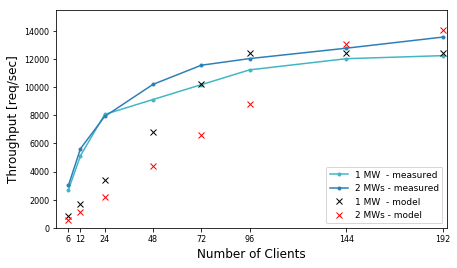

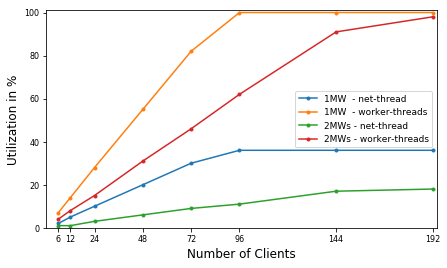

Read-Only


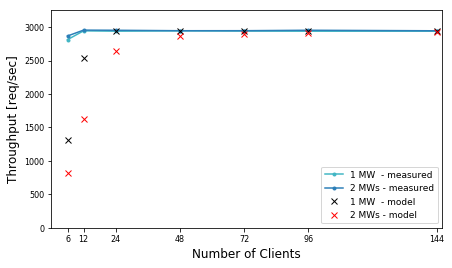

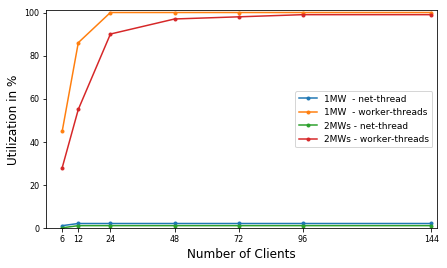

Saved Data: ./../../data/exp70/noq_write_only/processed_tp.log
Saved Data: ./../../data/exp70/noq_write_only/processed_util.log
Saved Data: ./../../data/exp70/noq_read_only/processed_tp.log
Saved Data: ./../../data/exp70/noq_read_only/processed_util.log


In [11]:
print("Write-Only")
generate(tp.network_queue, df_wo_tp, output_folder, "exp70_noq_tp_wo")
generate(utilization.network_queue, df_wo_util, output_folder, "exp70_noq_util_wo")

print("Read-Only")
generate(tp.network_queue, df_ro_tp, output_folder, "exp70_noq_tp_ro")
generate(utilization.network_queue, df_ro_util, output_folder, "exp70_noq_util_ro")

export(df_wo_tp, "noq_write_only", exp_name="exp70", suffix="_tp")
export(df_wo_util, "noq_write_only", exp_name="exp70", suffix="_util")

export(df_ro_tp, "noq_read_only", exp_name="exp70", suffix="_tp")
export(df_ro_util, "noq_read_only", exp_name="exp70", suffix="_util")

### Book Examples

In [12]:
m = 5
arrival_rate = 1/6
service_rate = 1/20

print(f"M/M/{m}")
U, R, Q, X, p0, pm = oc.eval(f"qsmmm({arrival_rate}, {service_rate}, {m})",nout=6)

print(f"Utilization = Traffic Intensity p = {U}")
print(f"Mean Response Time = {R}")
print(f"Mean number of jobs in system = {Q}")
print(f"Throughput= {X} (should be arrival rate in ergodic system)")
print(f"Probability of empty system = {p0}")
print(f"Probability of queuing = {pm}")

print("\nM/M/1")
arrival_rate = 125
service_rate = 500
U, R, Q, X, p0 = oc.eval(f"qsmm1({arrival_rate}, {service_rate})",nout=5)
print(f"Utilization = Traffic Intensity p = {U}")
print(f"Mean Response Time = {R}")
print(f"Mean number of jobs in system = {Q}")
print(f"Throughput= {X} (should be arrival rate in ergodic system)")
print(f"Probability of empty system = {p0}")

M/M/5
Utilization = Traffic Intensity p = 0.6666666666666666
Mean Response Time = 23.92003136025088
Mean number of jobs in system = 3.9866718933751466
Throughput= 0.16666666666666666 (should be arrival rate in ergodic system)
Probability of empty system = 0.03175225401803216
Probability of queuing = 0.3266692800209068

M/M/1
Utilization = Traffic Intensity p = 0.25
Mean Response Time = 0.0026666666666666666
Mean number of jobs in system = 0.3333333333333333
Throughput= 125.0 (should be arrival rate in ergodic system)
Probability of empty system = 0.75
